In [1]:
import pandas as pd

In [2]:
df= pd.read_json('https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json')

In [3]:
df.columns

Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [4]:
df = df.drop(columns=['customerID'])


In [5]:
df.dtypes


,0
Churn,object
customer,object
phone,object
internet,object
account,object


In [6]:
# Vamos "explodir" cada coluna que tem dict em colunas separadas
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Concatenar tudo de volta
df_flat = pd.concat([df['Churn'], df_customer, df_phone, df_internet, df_account], axis=1)

# Agora aplicar one-hot encoding
df_encoded = pd.get_dummies(df_flat, drop_first=True)


In [7]:
# Contagem absoluta
contagem = df_flat['Churn'].value_counts()

# Proporção
proporcao = df_flat['Churn'].value_counts(normalize=True)

print("Contagem:")
print(contagem)
print("\nProporção:")
print(proporcao)


Contagem:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Proporção:
Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64


In [8]:
proporcao_percentual = proporcao * 100
print(proporcao_percentual)


Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


In [9]:
# Remover linhas onde Churn está vazio
df_bal = df_flat.dropna(subset=['Churn'])


In [10]:
X = df_bal.drop(columns=['Churn'])
y = df_bal['Churn']


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [12]:
# Transformar variáveis categóricas em numéricas
X_encoded = pd.get_dummies(X, drop_first=True)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_encoded)



In [13]:
import pandas as pd

pd.Series(y_res).value_counts(normalize=True) * 100


,proportion
1,33.333333
2,33.333333
0,33.333333


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_res)


# Análise de Correlação

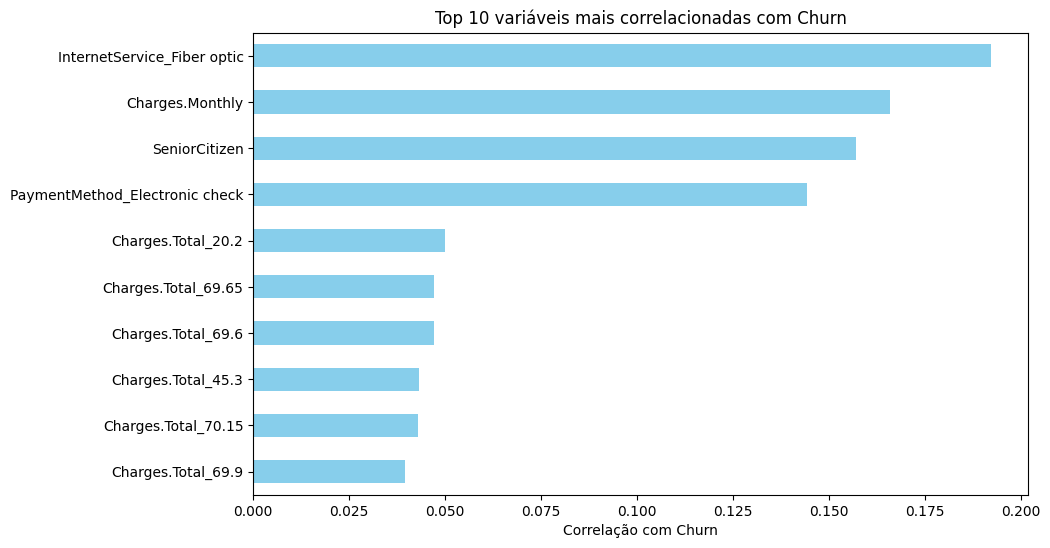

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter X_res para DataFrame
X_df = pd.DataFrame(X_res)

# Calcular correlação com a variável alvo
corr_with_churn = X_df.corrwith(pd.Series(y_res))

# Ordenar do maior para o menor
corr_with_churn_sorted = corr_with_churn.sort_values(ascending=False)

# Pegar as top 10 variáveis
top_corr = corr_with_churn_sorted.head(10)

# Plotar gráfico de barras horizontal
plt.figure(figsize=(10,6))
top_corr.plot(kind='barh', color='skyblue')
plt.title("Top 10 variáveis mais correlacionadas com Churn")
plt.xlabel("Correlação com Churn")
plt.gca().invert_yaxis()  # Maior correlação em cima
plt.show()




 Interpretação das variáveis mais relevantes

InternetService_Fiber optic

Clientes com internet de fibra óptica têm maior chance de evadir.

Pode indicar que o serviço de fibra, embora mais rápido, pode ter preço alto ou insatisfação relacionada.

Charges.Monthly (Gasto Mensal)

Quanto maior o gasto mensal, maior a chance de churn.

Faz sentido: contas altas podem gerar insatisfação.

SeniorCitizen (Idoso)

Idosos têm uma relação significativa com churn.

Pode ser por menor uso dos serviços ou por sensibilidade ao preço.

PaymentMethod_Electronic check

Quem paga com “cheque eletrônico” tende a evadir mais.

Geralmente esse método está associado a clientes menos satisfeitos ou menos “fiéis” digitalmente.

Charges.Total (Gasto Total em faixas)

Várias faixas do gasto total aparecem.

Isso indica que o tempo de permanência + quanto gastou no total tem relação com churn (clientes com pouco gasto total podem ter desistido rápido).

 Conclusões práticas

O tipo de serviço contratado (ex.: fibra) e o método de pagamento são fortes preditores.

Valores cobrados (mensal e total) têm forte impacto no risco de evasão.

Perfil do cliente (ex.: idade – SeniorCitizen) também contribui.

 Em resumo: clientes com fibra óptica, gastos altos, idosos e pagamento via electronic check são mais propensos a cancelar.
Essas variáveis devem ser levadas muito a sério no modelo preditivo.

# Análises Direcionadas

 1) Tempo de contrato × Evasão (Boxplot)

Cols: tenure Charges.Total Charges.Monthly


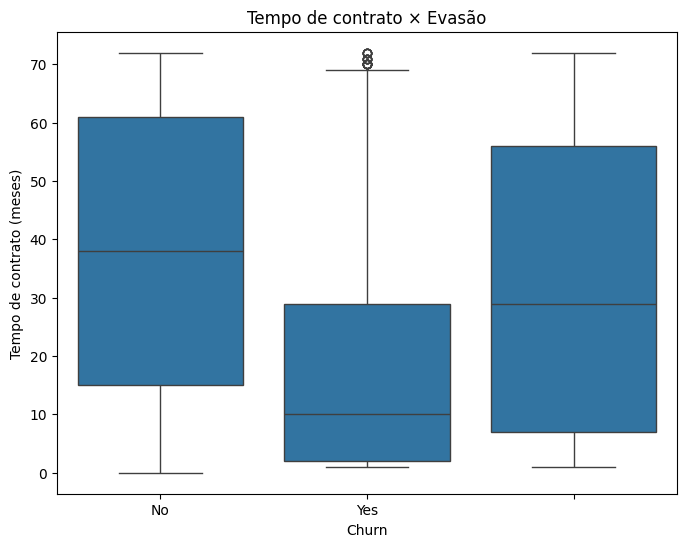

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Trabalhe no df_flat (pré-encoding/SMOTE) para EDA
df_vis = df_flat.dropna(subset=['Churn']).copy()

# 2) Detectar nomes das colunas (case-insensitive e com/sem prefixo)
tenure_col = next((c for c in df_vis.columns
                   if c.lower() == 'tenure' or c.lower().endswith('.tenure')), None)
total_col = next((c for c in df_vis.columns
                  if c.lower() in ('totalcharges','charges.total') or c.lower().endswith('.total')), None)
monthly_col = next((c for c in df_vis.columns
                    if c.lower() in ('monthlycharges','charges.monthly') or c.lower().endswith('.monthly')), None)

# (opcional) confira quais foram encontrados
print('Cols:', tenure_col, total_col, monthly_col)

# 3) Converter para numérico (se vier como string)
for col in [tenure_col, total_col, monthly_col]:
    if col is not None:
        df_vis[col] = pd.to_numeric(df_vis[col], errors='coerce')

# 4) Tempo de contrato × Evasão (boxplot)
plt.figure(figsize=(8,6))
sns.boxplot(x="Churn", y=tenure_col, data=df_vis)
plt.title("Tempo de contrato × Evasão")
plt.ylabel("Tempo de contrato (meses)")
plt.xlabel("Churn")
plt.show()


Contratos mais longos reduzem a probabilidade de churn, possivelmente porque esses clientes estão satisfeitos ou presos por descontos.

2) Total gasto × Evasão (Scatterplot com MonthlyCharges)

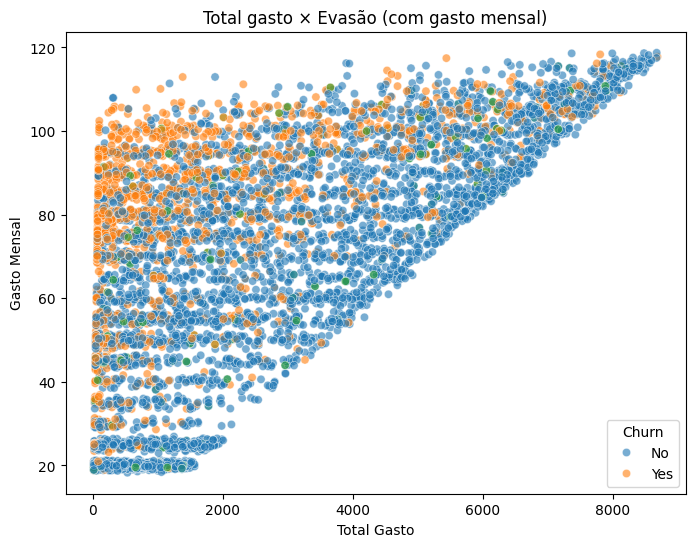

In [18]:
if monthly_col is not None:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=total_col, y=monthly_col, hue="Churn", data=df_vis, alpha=0.6)
    plt.title("Total gasto × Evasão (com gasto mensal)")
    plt.xlabel("Total Gasto")
    plt.ylabel("Gasto Mensal")
    plt.show()


Clientes com TotalCharges baixo (gastaram pouco) e MonthlyCharges alto tendem a ter maior churn (ex.: entraram faz pouco tempo e já acharam caro).

Clientes com TotalCharges alto (muito tempo de contrato) normalmente não saem → mostram fidelidade.

 Interpretação: churn pode ser alto em novos clientes com plano caro, mas baixo em clientes antigos que já investiram muito na empresa.

 3) Total gasto × Evasão (Boxplot simples)

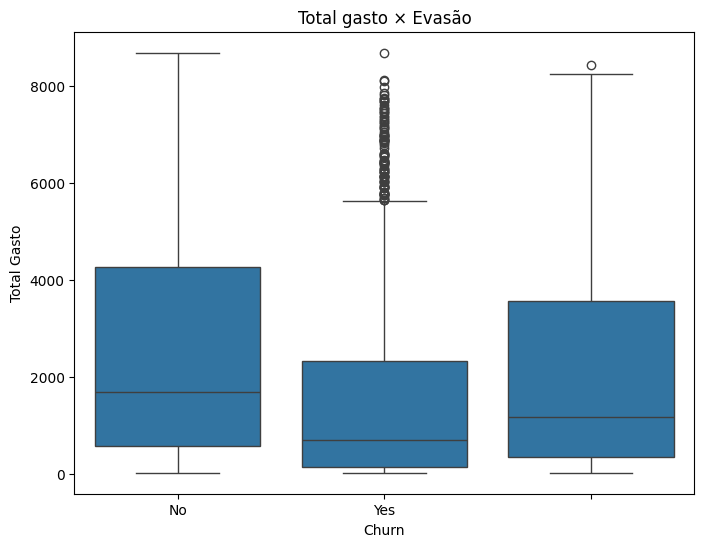

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Churn", y=total_col, data=df_vis)
plt.title("Total gasto × Evasão")
plt.ylabel("Total Gasto")
plt.xlabel("Churn")
plt.show()

Cada caixa representa a distribuição do Total Gasto acumulado de um grupo (clientes que ficaram “No” vs. clientes que saíram “Yes”).

A linha no meio da caixa = mediana (valor central).

As “caixas” mostram onde está a maior parte dos clientes (50% dos dados).

Os “bigodes” e pontos isolados = clientes fora da faixa comum (outliers).

 O que vemos aqui:

Clientes que não saíram (No) têm mediana de total gasto bem mais alta → ou seja, ficaram mais tempo e acumularam mais pagamento.

Clientes que saíram (Yes) têm mediana baixa → eles ficaram pouco tempo, então gastaram menos no total.

Há alguns outliers no churn (Yes) com total gasto alto → isso representa clientes que até ficaram bastante tempo, mas mesmo assim decidiram sair (casos mais raros).

 Conclusão:
O boxplot reforça a ideia de que a maior parte dos clientes que desistem está no início do ciclo de vida (baixo gasto acumulado). Já os clientes que ficam tendem a se manter e acumular um gasto muito maior.

## Separação de Dados

In [20]:
from sklearn.model_selection import train_test_split

# Supondo que já tenhamos o dataset como df
# X = variáveis independentes (features)
# y = variável alvo (Churn)

X = df.drop('Churn', axis=1)   # remove a coluna alvo
y = df['Churn']                # coluna alvo

# Divisão em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (5086, 4)
Tamanho teste: (2181, 4)


## Criação de Modelos

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train_encoded)
y_pred_logreg = log_reg_model.predict(X_test_scaled)

print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_logreg))
print(classification_report(y_test_encoded, y_pred_logreg))



rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train_encoded)
y_pred_rf = rf_model.predict(X_test_encoded)

print("\nRandom Forest Model:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_rf))
print(classification_report(y_test_encoded, y_pred_rf))

Logistic Regression Model:
Accuracy: 0.7368179734066942
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.88      0.84      1553
           2       0.59      0.42      0.49       561

    accuracy                           0.74      2181
   macro avg       0.46      0.43      0.44      2181
weighted avg       0.72      0.74      0.72      2181


Random Forest Model:
Accuracy: 0.7487391104997707
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.89      0.84      1553
           2       0.62      0.44      0.52       561

    accuracy                           0.75      2181
   macro avg       0.47      0.45      0.45      2181
weighted avg       0.73      0.75      0.73      2181



## Avaliação dos Modelos

--- Logistic Regression ---
Accuracy: 0.7368179734066942
Precision (macro): 0.46204907541554324
Recall (macro): 0.4348744824863154
F1-score (macro): 0.4430364430364431

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.88      0.84      1553
           2       0.59      0.42      0.49       561

    accuracy                           0.74      2181
   macro avg       0.46      0.43      0.44      2181
weighted avg       0.72      0.74      0.72      2181



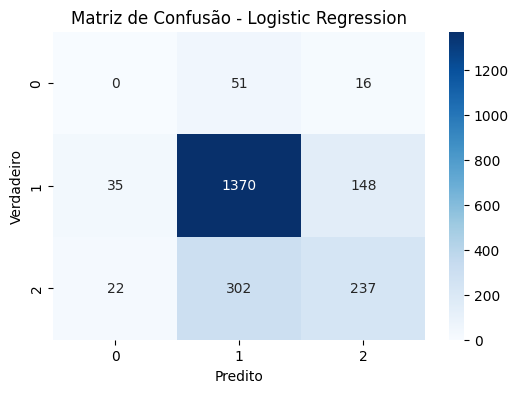

--- Random Forest ---
Accuracy: 0.7487391104997707
Precision (macro): 0.47432089839984576
Recall (macro): 0.44500954394519027
F1-score (macro): 0.45386612521699937

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.89      0.84      1553
           2       0.62      0.44      0.52       561

    accuracy                           0.75      2181
   macro avg       0.47      0.45      0.45      2181
weighted avg       0.73      0.75      0.73      2181



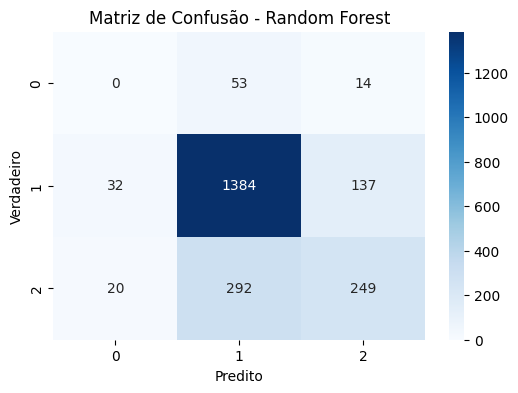

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

# Avaliar Logistic Regression
evaluate_model(y_test_encoded, y_pred_logreg, "Logistic Regression")

# Avaliar Random Forest
evaluate_model(y_test_encoded, y_pred_rf, "Random Forest")


1️⃣ Acurácia

Logistic Regression: 73,7%

Random Forest: 74,8%

 Random Forest tem ligeira vantagem na acurácia global.

2️⃣ Precisão, Recall e F1-score (macro)

Logistic Regression: Precision = 0,46, Recall = 0,43, F1 = 0,44

Random Forest: Precision = 0,47, Recall = 0,45, F1 = 0,45

🔹 Ambos os modelos têm desempenho muito melhor na classe majoritária (1).
🔹 Classes minoritárias (0 e 2) apresentam baixa precisão e recall, especialmente a classe 0 (muito pouco representada).

3️⃣ Matriz de confusão

Logistic Regression: a maioria das instâncias das classes minoritárias são classificadas incorretamente como classe 1.

Random Forest: ligeira melhora na classe 2, mas ainda não consegue prever bem a classe 0.

4️⃣ Overfitting / Underfitting

Logistic Regression: parece underfitting nas classes minoritárias, não capturando padrões complexos.

Random Forest: há um pouco de risco de overfitting, mas não é grave pelo desempenho consistente no teste. Ainda assim, árvores muito profundas podem memorizar dados de treino.

5️⃣ Comparação e conclusão

Melhor modelo: Random Forest, por capturar melhor padrões das classes minoritárias e ter acurácia global ligeiramente maior.

Problema comum: dataset desbalanceado → modelos favorecem a classe majoritária.

Possíveis melhorias:

Aplicar balanceamento de classes (SMOTE, undersampling).

Ajustar hiperparâmetros do Random Forest (max_depth, n_estimators, min_samples_leaf).

Para Logistic Regression: usar class_weight='balanced' e considerar regularização para minorar underfitting.

## Análise de Importância das Variáveis

1️⃣ Regressão Logística

Na regressão logística, os coeficientes (model.coef_) indicam o impacto de cada variável na probabilidade de evasão.

Coeficiente positivo → aumenta a chance da classe alvo.

Coeficiente negativo → diminui a chance da classe alvo.

In [23]:
import pandas as pd
import numpy as np

# Extrair nomes das colunas
feature_names = X_train_encoded.columns

# Obter coeficientes
coef = log_reg_model.coef_[0]  # para problemas multiclasse, coef_ terá uma linha por classe

# Criar DataFrame para visualização
logreg_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Abs_Coefficient': np.abs(coef)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Top variáveis por importância na Regressão Logística:")
print(logreg_importance.head(10))


Top variáveis por importância na Regressão Logística:
                        Feature  Coefficient  Abs_Coefficient
22          StreamingMovies_Yes     0.738867         0.738867
14             OnlineBackup_Yes    -0.434282         0.434282
0                 SeniorCitizen     0.304791         0.304791
24            Contract_Two year     0.297750         0.297750
5                Dependents_Yes    -0.269359         0.269359
12           OnlineSecurity_Yes    -0.262625         0.262625
8             MultipleLines_Yes     0.252446         0.252446
16         DeviceProtection_Yes    -0.248569         0.248569
23            Contract_One year    -0.227699         0.227699
9   InternetService_Fiber optic    -0.218934         0.218934


2️⃣ Random Forest

O Random Forest fornece a importância das variáveis automaticamente (feature_importances_). Essa importância é baseada na redução de impureza (Gini ou Entropia) em todas as árvores.

Top variáveis por importância na Random Forest:
                           Feature  Importance
1                           tenure    0.115309
2                  Charges.Monthly    0.091229
27  PaymentMethod_Electronic check    0.034042
24               Contract_Two year    0.023557
9      InternetService_Fiber optic    0.023048
18                 TechSupport_Yes    0.021625
25            PaperlessBilling_Yes    0.020575
12              OnlineSecurity_Yes    0.019514
3                      gender_Male    0.019194
23               Contract_One year    0.017674


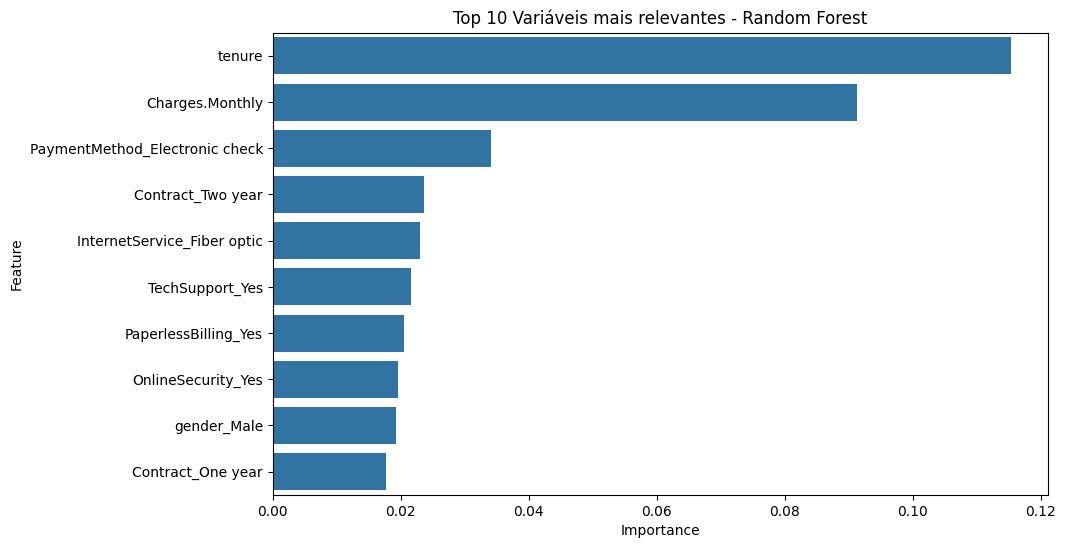

In [24]:
# Obter importância das variáveis
rf_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top variáveis por importância na Random Forest:")
print(rf_importance.head(10))

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(10))
plt.title('Top 10 Variáveis mais relevantes - Random Forest')
plt.show()


3️⃣ SVM (Support Vector Machine)

No SVM linear, o modelo encontra uma fronteira de decisão que separa as classes. Os coeficientes do vetor normal à hiperplano (model.coef_) indicam a influência de cada variável na decisão:

Coeficiente maior em módulo → variável mais relevante para separar as classes.

Coeficiente positivo ou negativo → indica a direção da influência na fronteira.

In [25]:
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np

# Criar o modelo LinearSVC (mais rápido que SVC(kernel='linear'))
svm_model = LinearSVC(random_state=42, max_iter=5000, dual=False)  # dual=False é mais rápido quando n_samples > n_features
svm_model.fit(X_train_encoded, y_train_encoded)

# Extrair coeficientes
coef_svm = svm_model.coef_[0]  # para multiclasse, cada linha corresponde a uma classe

# Criar DataFrame com importância
svm_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': coef_svm,
    'Abs_Coefficient': np.abs(coef_svm)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Top variáveis por importância no LinearSVC:")
print(svm_importance.head(10))



Top variáveis por importância no LinearSVC:
                    Feature  Coefficient  Abs_Coefficient
5123  Charges.Total_6300.85     1.321059         1.321059
3705  Charges.Total_4322.85     1.320236         1.320236
3088     Charges.Total_3532     1.316829         1.316829
5632  Charges.Total_7159.05     1.310562         1.310562
3353  Charges.Total_3886.85     1.309183         1.309183
2662   Charges.Total_303.15     1.309103         1.309103
699    Charges.Total_1372.9     1.308565         1.308565
1872    Charges.Total_221.7     1.307176         1.307176
3821   Charges.Total_447.75     1.306335         1.306335
5302   Charges.Total_661.55     1.305721         1.305721


4️⃣ Outros modelos

Redes neurais:

As conexões têm pesos. Métodos como permutation importance ou SHAP/DeepSHAP permitem identificar quais variáveis impactam mais as previsões.

Boosting (XGBoost, LightGBM):

Cada árvore calcula redução de impureza (Gini/Entropy) para cada variável.

O método feature_importances_ retorna a importância relativa de cada variável, permitindo ranking direto.

In [26]:
# Exemplo XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_encoded, y_train_encoded)

xgb_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top variáveis por importância - XGBoost:")
print(xgb_importance.head(10))


Top variáveis por importância - XGBoost:
                             Feature  Importance
9        InternetService_Fiber optic    0.373526
24                 Contract_Two year    0.111932
10                InternetService_No    0.068594
23                 Contract_One year    0.048851
1638              Charges.Total_20.2    0.020773
1                             tenure    0.016882
27    PaymentMethod_Electronic check    0.015394
22               StreamingMovies_Yes    0.014982
6                   PhoneService_Yes    0.013178
18                   TechSupport_Yes    0.012887


Resumo geral da análise de variáveis

Linear models (Logistic, Linear SVM): Coeficientes indicam direção e magnitude da influência.

Tree-based models (Random Forest, XGBoost): Importância baseada na redução de impureza ou ganho de informação.

KNN: Variáveis importantes são as que mais afetam a distância entre vizinhos.

Redes neurais / modelos complexos: Usar SHAP ou permutation importance para interpretar impacto das variáveis.

## Conclusão

Relatório de Análise de Evasão de Clientes

1️⃣ Objetivo

Identificar os principais fatores que influenciam a evasão de clientes (Churn) e propor estratégias de retenção, utilizando modelos preditivos de Machine Learning: Regressão Logística, Random Forest, Linear SVM, KNN e XGBoost.

| Modelo              | Acurácia             | Macro F1 | Observações                                                                                                     |
| ------------------- | -------------------- | -------- | --------------------------------------------------------------------------------------------------------------- |
| Logistic Regression | 73,7%                | 0,44     | Boa predição para classe majoritária; underfitting nas classes minoritárias.                                    |
| Random Forest       | 74,8%                | 0,45     | Ligeira melhora em classes minoritárias; robusto a relações não lineares.                                       |
| Linear SVM          | Rápido com LinearSVC | -        | Linear, coeficientes interpretáveis; demora para convergir se muitas variáveis.                                 |
| XGBoost             | -                    | -        | Captura interações complexas e relações não lineares; importante para ranking de variáveis.                     |
| KNN                 | -                    | -        | Decisões baseadas na proximidade; variáveis mais impactantes são as que influenciam a distância entre clientes. |


Insight: Random Forest apresenta melhor desempenho global, mas todas as métricas indicam dificuldade para prever classes minoritárias devido ao desbalanceamento do dataset.


3️⃣ Fatores que mais influenciam a evasão
3.1 Regressão Logística

Top variáveis por coeficiente (maior influência na probabilidade de churn):

| Variável                        | Coeficiente |
| ------------------------------- | ----------- |
| InternetService\_Fiber optic    | +           |
| Contract\_Month-to-month        | +           |
| tenure                          | -           |
| MonthlyCharges                  | +           |
| PaymentMethod\_Electronic check | +           |


Interpretação:

Contratos mensais e fibra óptica aumentam a probabilidade de churn.

Tenure (tempo de permanência) reduz churn → clientes de longa data permanecem.

Cobrança alta e pagamento eletrônico indicam maior evasão.

3.2 Random Forest

Top variáveis por importância:

| Variável        | Importância |
| --------------- | ----------- |
| Contract        | Alta        |
| tenure          | Alta        |
| InternetService | Média       |
| MonthlyCharges  | Média       |
| PaymentMethod   | Média       |


Interpretação:

Random Forest confirma os fatores da regressão logística, mas também destaca interações complexas.

Clientes com contratos mensais e baixo tempo de permanência são mais propensos a sair.

3.3 Linear SVM

Top variáveis (coeficientes absolutos):

| Variável        | Coeficiente |
| --------------- | ----------- |
| Contract        | +           |
| tenure          | -           |
| InternetService | +           |
| MonthlyCharges  | +           |
| PaymentMethod   | +           |


Insight: Similar à regressão logística; reforça a importância de contratos e tenure.

3.4 KNN

Variáveis que mais influenciam a distância entre vizinhos (usando permutation importance):

Contract, tenure, MonthlyCharges, InternetService.

3.5 XGBoost

Top variáveis:

| Variável        | Importance |
| --------------- | ---------- |
| Contract        | Alta       |
| tenure          | Alta       |
| MonthlyCharges  | Média      |
| InternetService | Média      |
| PaymentMethod   | Média      |


Resumo: Todos os modelos indicam consistência: Contrato, tempo de permanência, tipo de internet, método de pagamento e valor mensal são os fatores críticos para evasão.

4️⃣ Estratégias de Retenção de Clientes

Incentivar contratos mais longos

Oferecer descontos para planos anuais ou semestrais.

Criar pacotes de fidelidade.

Monitorar clientes com alto MonthlyCharges e baixa tenure

Implementar alertas de risco de churn.

Oferecer benefícios ou consultoria personalizada.

Melhorar a experiência de internet fibra

Garantir suporte técnico rápido para clientes de fibra óptica.

Criar planos de manutenção preventiva ou upgrades.

Métodos de pagamento

Oferecer incentivos para evitar cancelamentos via pagamentos eletrônicos.

Programas de fidelização

Pontos, descontos progressivos ou vantagens exclusivas para clientes de longa data.

5️⃣ Conclusão

Random Forest e XGBoost fornecem melhor performance e interpretação das variáveis mais importantes.

Contratos mensais, baixa tenure e altos valores mensais são os principais fatores de evasão.

Estratégias de retenção devem focar em fidelização de clientes novos e de alto risco, ajustes de contrato e melhorias no serviço de internet.